# SurvivalLVQ example notebook
The notebook provides a detailed demonstration of the SurvivalLVQ algorithm's implementation, showcasing its application using the PCB3 dataset.

**Load required libraries**

In [1]:
import torch
from Models.SurvivalLVQ import SurvivalLVQ
from SkewTransformer import SkewTransformer
from datasets import load_dataset
import numpy as np
from sklearn.model_selection import train_test_split
from sksurv.util import Surv
from sklearn.impute import SimpleImputer
from sksurv.compare import compare_survival
from utils import score_brier, score_CI, score_CI_ipcw

# reproducible results
torch.manual_seed(42)
np.random.seed(42)

**Load the data**
In this step, the data is loaded, and a train/test set is established. The censoring status serves as a stratifier to ensure an equal distribution of the censoring rate across both sets.
Additionally, a custom transformer is employed to apply a z-transformation and conduct skew correction.

In [2]:
# Explore the Pbc3 dataset
print("=== Dataset Exploration: Pbc3 ===\n")

# Load the dataset to explore it
data, fac_col_ids, num_col_ids, T, D = load_dataset('Pbc3')

print(f"Dataset shape: {data.shape}")
print(f"Number of samples: {data.shape[0]}")
print(f"Number of features: {data.shape[1]}")
print(f"Categorical feature indices: {fac_col_ids}")
print(f"Numerical feature indices: {num_col_ids}")

print(f"\nFeature names:")
for i, col in enumerate(data.columns):
    feature_type = "categorical" if i in fac_col_ids else "numerical"
    print(f"  {i}: {col} ({feature_type})")

print(f"\nSurvival time statistics:")
print(f"  Min time: {T.min():.2f}")
print(f"  Max time: {T.max():.2f}")
print(f"  Mean time: {T.mean():.2f}")
print(f"  Median time: {T.median():.2f}")

print(f"\nCensoring information:")
print(f"  Number of events (deaths): {D.sum()}")
print(f"  Number of censored: {(~D).sum()}")
print(f"  Censoring rate: {(~D).mean():.3f}")

print(f"\nMissing values per feature:")
for i, col in enumerate(data.columns):
    missing_count = data[col].isna().sum()
    missing_pct = (missing_count / len(data)) * 100
    print(f"  {col}: {missing_count} ({missing_pct:.1f}%)")

print(f"\nFirst few rows of the dataset:")
print(data.head())



=== Dataset Exploration: Pbc3 ===

Dataset shape: (349, 19)
Number of samples: 349
Number of features: 19
Categorical feature indices: [ 0  1  2  3  4  5  6  7  8  9 10 11]
Numerical feature indices: [12 13 14 15 16 17 18]

Feature names:
  0: fac_unit_2 (categorical)
  1: fac_unit_3 (categorical)
  2: fac_unit_4 (categorical)
  3: fac_unit_5 (categorical)
  4: fac_unit_6 (categorical)
  5: fac_tment_1 (categorical)
  6: fac_sex_1 (categorical)
  7: fac_stage_2 (categorical)
  8: fac_stage_3 (categorical)
  9: fac_stage_4 (categorical)
  10: fac_stage_missing (categorical)
  11: fac_gibleed_1 (categorical)
  12: num_age (numerical)
  13: num_crea (numerical)
  14: num_alb (numerical)
  15: num_bili (numerical)
  16: num_alkph (numerical)
  17: num_asptr (numerical)
  18: num_weight (numerical)

Survival time statistics:
  Min time: 1.00
  Max time: 2146.00
  Mean time: 942.65
  Median time: 929.00

Censoring information:
  Number of events (deaths): 61
  Number of censored: -410
  Cens

In [3]:
data, fac_col_ids, num_col_ids, T, D = load_dataset('Pbc3')
X = data.astype(float).to_numpy()                  # covariates
D = D.to_numpy()                                   # censoring indicator
T = T.to_numpy()                                   # survival time
Y = Surv().from_arrays(D.astype('?'), T)           # convert (D, T) to survival object

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, stratify=D, random_state=42
) # split data into training and test sets w/ 8:2 ration and stratify by censoring indicator

imp = SimpleImputer(missing_values=np.nan, strategy='median') # impute missing values with median

X_train = imp.fit_transform(X_train)
X_test = imp.fit_transform(X_test)

# transform numerical features if there are any
if len(num_col_ids) > 0: 
    scaler = SkewTransformer() # transform numerical features to have a normal distribution
    scaler.fit(X_train[:, num_col_ids])
    X_train[:, num_col_ids] = scaler.transform(X_train[:, num_col_ids])
    X_test[:, num_col_ids] = scaler.transform(X_test[:, num_col_ids])

**Fit the model**

In [4]:
model = SurvivalLVQ(n_prototypes=3, batch_size=128, lr=7e-3,
                              epochs=50, device=torch.device("cpu"), verbose=True)
model.fit(X_train, Y_train)

Epoch: 1 / 50 | Loss: 0.033926
Epoch: 2 / 50 | Loss: 0.034929
Epoch: 3 / 50 | Loss: 0.033135
Epoch: 4 / 50 | Loss: 0.034107
Epoch: 5 / 50 | Loss: 0.033381
Epoch: 6 / 50 | Loss: 0.033174
Epoch: 7 / 50 | Loss: 0.031892
Epoch: 8 / 50 | Loss: 0.032359
Epoch: 9 / 50 | Loss: 0.028722
Epoch: 10 / 50 | Loss: 0.028453
Epoch: 11 / 50 | Loss: 0.029272
Epoch: 12 / 50 | Loss: 0.027792
Epoch: 13 / 50 | Loss: 0.029975
Epoch: 14 / 50 | Loss: 0.027758
Epoch: 15 / 50 | Loss: 0.030081
Epoch: 16 / 50 | Loss: 0.025911
Epoch: 17 / 50 | Loss: 0.026938
Epoch: 18 / 50 | Loss: 0.030174
Epoch: 19 / 50 | Loss: 0.028347
Epoch: 20 / 50 | Loss: 0.030183
Epoch: 21 / 50 | Loss: 0.027474
Epoch: 22 / 50 | Loss: 0.027509
Epoch: 23 / 50 | Loss: 0.027907
Epoch: 24 / 50 | Loss: 0.027246
Epoch: 25 / 50 | Loss: 0.025645
Epoch: 26 / 50 | Loss: 0.026741
Epoch: 27 / 50 | Loss: 0.026344
Epoch: 28 / 50 | Loss: 0.026604
Epoch: 29 / 50 | Loss: 0.026690
Epoch: 30 / 50 | Loss: 0.025496
Epoch: 31 / 50 | Loss: 0.027660
Epoch: 32 / 50 | 

SurvivalLVQ()

**Prediction and performance scoring**

In [5]:
predicted = model.predict(X_test)

score_CI = score_CI(model, X_test, Y_test)
print("CI test:", score_CI)

score_CI_ipcw = score_CI_ipcw(model, X_test, Y_train, Y_test)
print("CI ipcw test:", score_CI_ipcw)

score_brier = score_brier(model, X_test, Y_train, Y_test)
print("brier test:", score_brier)

CI test: 0.8188824662813102
CI ipcw test: 0.44872263512096205
brier test: 0.07924784708169089


**Model visualisation**

variance coverd by projection: tensor(63.2158)


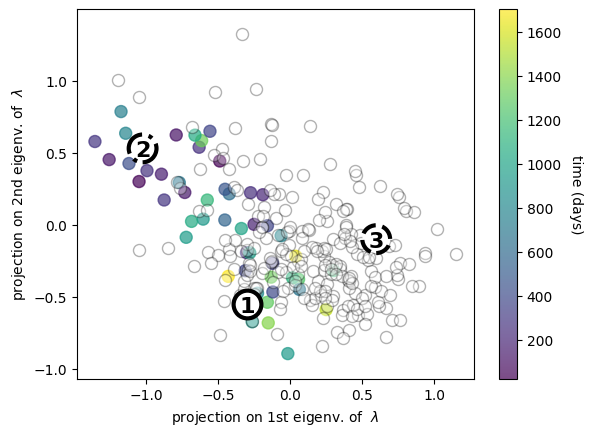

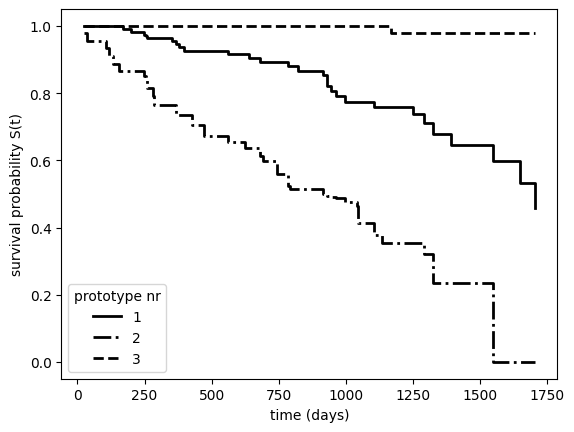

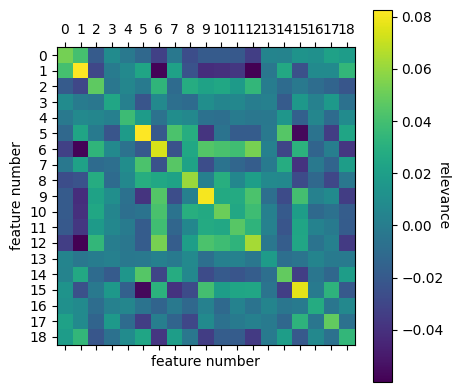

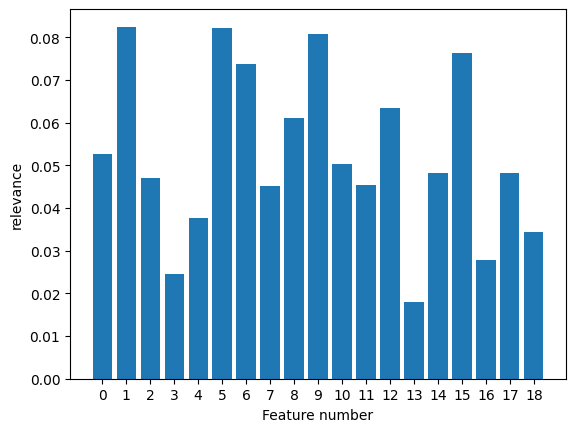

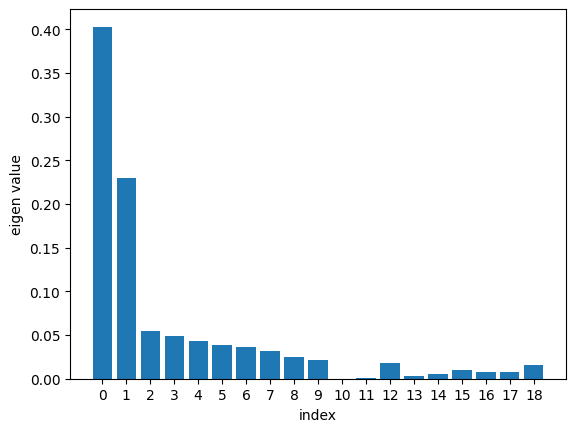

In [6]:
D_train, T_train = map(np.array, zip(*Y_train))
model.vis(X_train, D_train, T_train)

**check for statistical significance between groups**

In [7]:
group = model.predict(X_train, closest=True)
comp = compare_survival(Y_train, group)
print("group comparison", comp)

group comparison (np.float64(87.90871403626745), np.float64(8.144516198870067e-20))


In [8]:
a, b, c = [1, 2, 3]

print(a, b, c)

1 2 3
